<a href="https://colab.research.google.com/github/changsin/CV/blob/main/2.10.segmentation_thresholding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentation & Thresholding

## Otsu's Method: Optimal Global Thresholding

The best threshold $T$ is the one that minimizes the intra-class variance (variance within the foreground and background classes) or, equivalently, maximizes the inter-class variance (variance between the two classes).

Intra-Class Variance ($\sigma_W^2$):

$$\sigma_W^2(T) = \omega_0(T) \sigma_0^2(T) + \omega_1(T) \sigma_1^2(T)$$

- $\omega_0, \omega_1$: Probability of each (Background/Foreground).
- $\sigma_0^2, \sigma_1^2$: Variance of each class intensity.

Otsu's Algorithm: Iteratively search for $T$ (from 0 to 255) that minimizes $\sigma_W^2(T)$. The result is a highly effective, unsupervised binarization.


### Steps

1. Probability of Each Gray Level:
$$ p_i = \frac{n_i}{N} $$

- $ i $: gray level (from 0 to L-1)
- $ n_i $: number of pixels with intensity $i$
- $N$: total number of pixels in the image

2. Class probabilities:
$$ \omega_1(t) = \sum_{i=0}^{t} p_i, \quad \omega_2(t) = \sum_{i=t+1}^{L-1} p_i $$

- $t$: threshold value (candidate intensity)
- $ \omega_1(t)$: probability (weight) of class 1 (background pixels)

- $ \omega_2(t)$: probability (weight) of class 2 (foreground pixels)
	​

(t): probability (weight) of class 2 (foreground pixels)

- $p_i$: probability (normalized histogram) of intensity $i$
- $L$: number of possible gray levels (usually 256)

Otsu's optimal threshold = 169


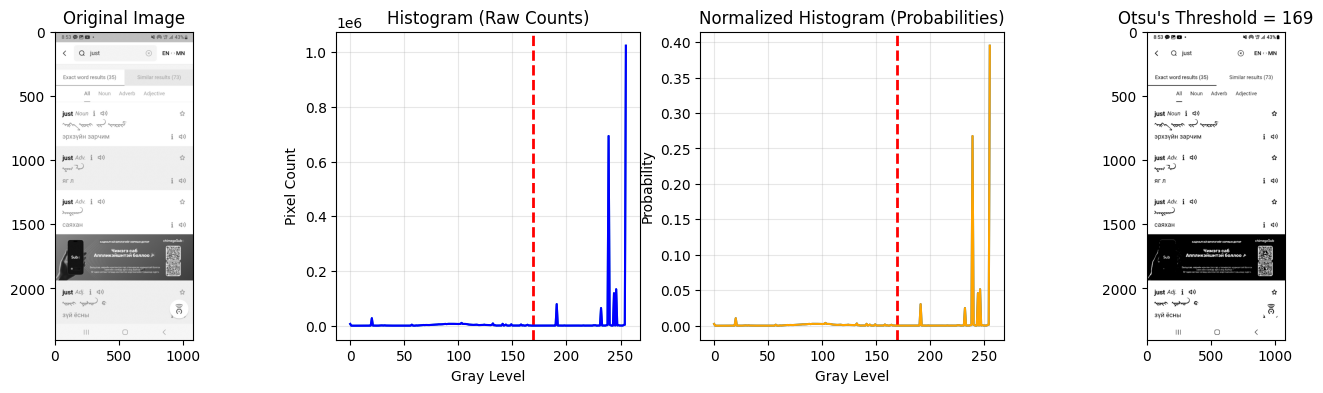

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load grayscale image
img = cv2.imread('Screenshot1.jpg', cv2.IMREAD_GRAYSCALE)

# Step 1: Compute histogram
hist, bins = np.histogram(img.ravel(), bins=256, range=(0, 256))
p = hist / hist.sum()  # normalized histogram (probabilities)

# Step 2: Compute cumulative sums and means
omega = np.cumsum(p)  # cumulative class probabilities
mu = np.cumsum(p * np.arange(256))  # cumulative means

# Step 3: Global mean
mu_t = mu[-1]

# Step 4: Compute between-class variance
sigma_b_squared = (mu_t * omega - mu)**2 / (omega * (1 - omega) + 1e-10)

# Step 5: Find threshold that maximizes variance
T = np.argmax(sigma_b_squared)

print("Otsu's optimal threshold =", T)

# Step 6: Apply threshold
_, otsu_img = cv2.threshold(img, T, 255, cv2.THRESH_BINARY)

# Display results
plt.figure(figsize=(18,4))

plt.subplot(1,4,1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')

plt.subplot(1,4,2)
plt.plot(hist) # Plot the original histogram
plt.axvline(T, color='r', linestyle='dashed', linewidth=2)
# plt.title('Original Histogram')
# plt.xlabel('Pixel Intensity')
# plt.ylabel('Frequency')
plt.plot(hist, color='blue')
plt.title('Histogram (Raw Counts)')
plt.xlabel('Gray Level')
plt.ylabel('Pixel Count')
plt.grid(True, alpha=0.3)


plt.subplot(1,4,3)
plt.plot(p) # Plot the normalized histogram
plt.axvline(T, color='r', linestyle='dashed', linewidth=2) # Threshold should not be scaled for normalized histogram
# plt.title('Normalized Histogram')
# plt.xlabel('Pixel Intensity') # Label remains Pixel Intensity
# plt.ylabel('Probability')
plt.plot(p, color='orange')
plt.title('Normalized Histogram (Probabilities)')
plt.xlabel('Gray Level')
plt.ylabel('Probability')
plt.grid(True, alpha=0.3)

plt.subplot(1,4,4)
plt.imshow(otsu_img, cmap='gray')
plt.title(f"Otsu's Threshold = {T}")

plt.show()